In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn.base import BaseEstimator, TransformerMixin

# Evitar warnings en la salida
warnings.filterwarnings("ignore")

# %matplotlib inline -> Solo se requiere si usas Jupyter, en otros casos se omite

%matplotlib inline

csv_path = '/content/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv
#Xdata.to_excel('excel_fifa_2019.xlsx', index=False)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [2]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

In [3]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

print('Xtrain=', Xtrain.shape, 'Xtest=',Xtest.shape,'ytrain=', ytrain.shape, 'ytest=', ytest.shape)

Xtrain= (12744, 81) Xtest= (5463, 81) ytrain= (12744,) ytest= (5463,)


In [4]:

imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print('ytrain=', ytrain.shape, 'ytest=', ytest.shape)

ytrain= (12744,) ytest= (5463,)


In [5]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc

In [6]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [7]:
ytrain_num[:5]

array([ 958000.,  449000.,  935000., 6500000., 1100000.])

In [8]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = []
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [9]:
Xdata['Nationality'].value_counts()

,count
Nationality,
England,1662
Germany,1198
Spain,1072
Argentina,937
France,914
...,...
New Caledonia,1
Fiji,1
São Tomé & Príncipe,1


In [10]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [11]:
cat_usr['Body Type']

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'C. Ronaldo',
 'Neymar',
 'Courtois',
 'PLAYER_BODY_TYPE_25',
 'Shaqiri',
 'Akinfenwa']

In [12]:
class mypre_fifa(BaseEstimator, TransformerMixin):
    def __init__(self, col_euro, col_stats, cat_usr):
        self.col_euro = col_euro  # Columnas tipo moneda
        self.col_stats = col_stats  # Columnas tipo estadística
        self.cat_usr = cat_usr  # Columnas categóricas

    def fit(self, X, *_):
        Xi = X.copy()
        # Manejo de valores faltantes
        self.imputer_num = SimpleImputer(strategy="most_frequent")
        self.cols_with_nan = Xi.columns[Xi.isna().any()].tolist()
        self.imputer_num.fit(Xi[self.cols_with_nan])
        Xi[self.cols_with_nan] = self.imputer_num.transform(Xi[self.cols_with_nan])

        # Codificación de columnas tipo moneda y estadística
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

        # Conversión de 'Height' y 'Weight'
        Xi['Height'].replace(regex=["'"], value='.', inplace=True)
        Xi['Weight'] = Xi['Weight'].str[:-3].astype(float)
        Xi['Height'] = Xi['Height'].astype(float)

        # Codificación de fechas
        Xi['Joined'] = Xi['Joined'].replace(regex="/", value="").astype(float)

        # Codificación de columnas categóricas con OrdinalEncoder
        cat = [self.cat_usr[key] for key in self.cat_usr.keys()]
        self.col_cat_usr = OrdinalEncoder(categories=cat)
        Xi[[*self.cat_usr.keys()]] = self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])

        return self

    def transform(self, X, *_):
        Xi = X.copy()

        # Imputación de valores faltantes
        Xi[self.cols_with_nan] = self.imputer_num.transform(Xi[self.cols_with_nan])

        # Codificación de columnas tipo moneda y estadística
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

        # Conversión de 'Height' y 'Weight'
        Xi['Height'].replace(regex=["'"], value='.', inplace=True)
        Xi['Weight'] = Xi['Weight'].str[:-3].astype(float)
        Xi['Height'] = Xi['Height'].astype(float)

        # Codificación de fechas
        Xi['Joined'] = Xi['Joined'].replace(regex="/", value="").astype(float)

        # Transformación de columnas categóricas
        Xi[[*self.cat_usr.keys()]] = self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])

        return Xi

    def fit_transform(self, X, *_):
        self.fit(X)
        return self.transform(X)


In [13]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

In [14]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [15]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 11970 to 3939
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Fac

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [16]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [17]:
Xm =pd.DataFrame(Xtrain_pre[['Age','Overall','Potential']],columns=['Age','Overall','Potential'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['output'] = ytrain_num
corr_matrix2 = Xtrain_pre2.corr()#matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')




In [18]:
abs(corr_matrix2["output"]).sort_values(ascending=False)

,output
output,1.000000
Value,0.971926
Wage,0.821184
International Reputation,0.616287
Overall,0.593140
...,...
GKDiving,0.012355
GKReflexes,0.012113
GKPositioning,0.011615
Preferred Foot,0.011529


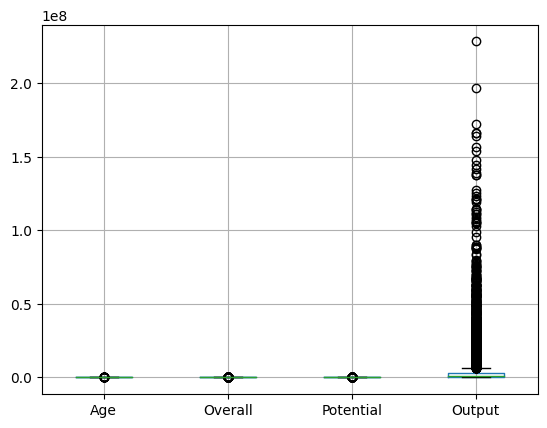

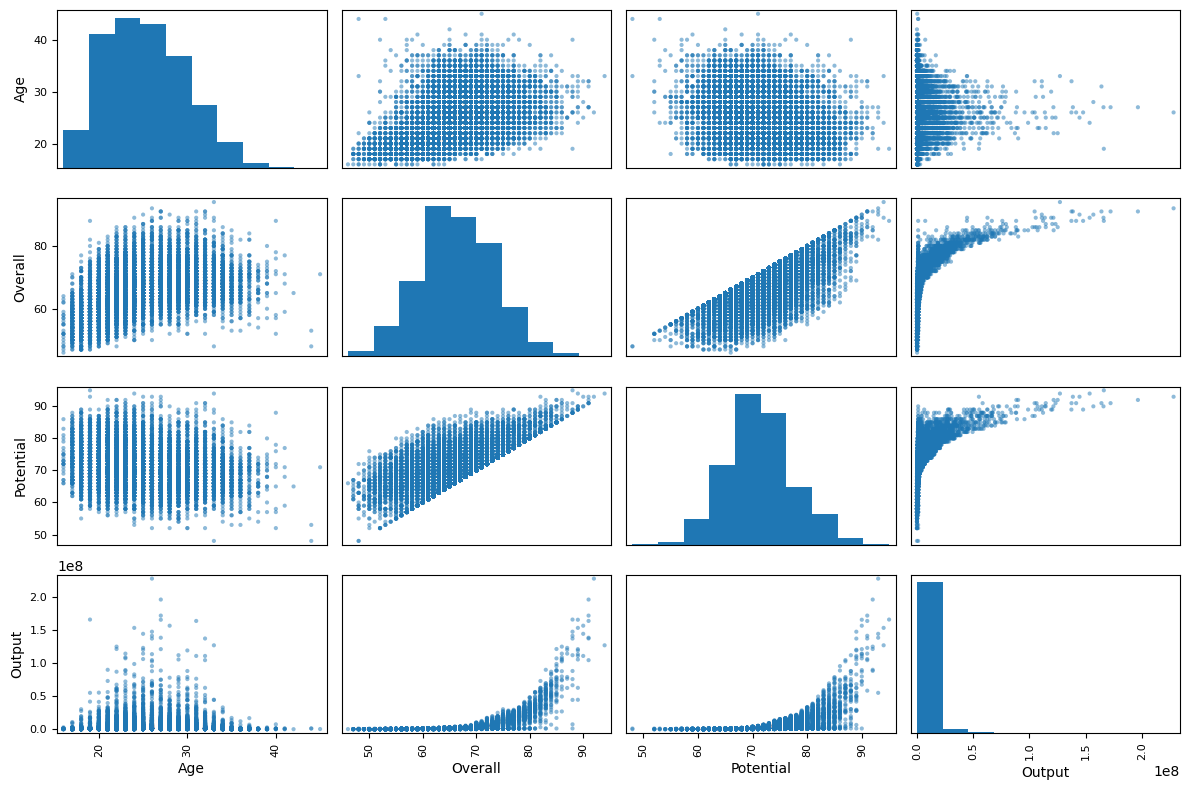

In [19]:

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

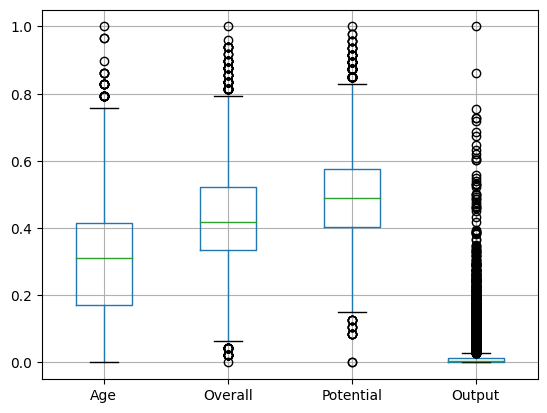

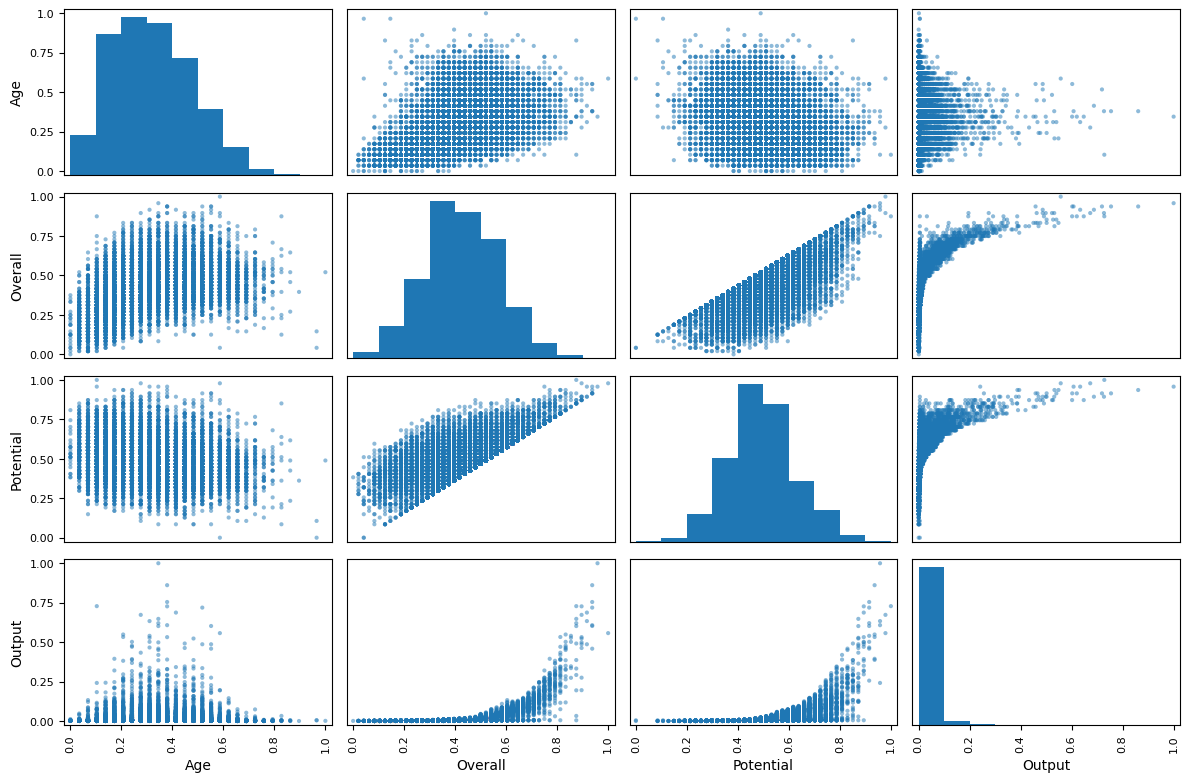

In [20]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()


In [21]:
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'C. Ronaldo',
                                                   'Neymar', 'Courtois',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['FC Barcelona', 'Valencia CF',
                                              'Fortuna Düsseldorf',
                                              'Cardiff City', 'Rayo Vallecano',
                                              'CD Leganés', 'Frosinone',
                                              'Newcastle United', 'Southampton',
                                              'Burnley', 'Eintracht Frankfurt',
                                              'Wolve...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Medium',
                                                   'Medium/ High', 'High/ High',
                                                   'Medium/ Low', 'High/ Low',
                                                   'Low/ Medium', 'Low/ High',
                                                   'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [22]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


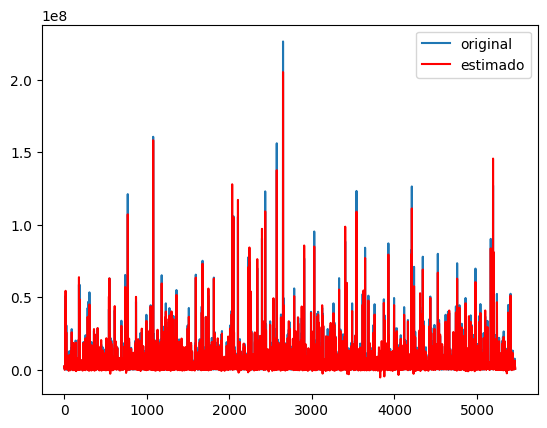

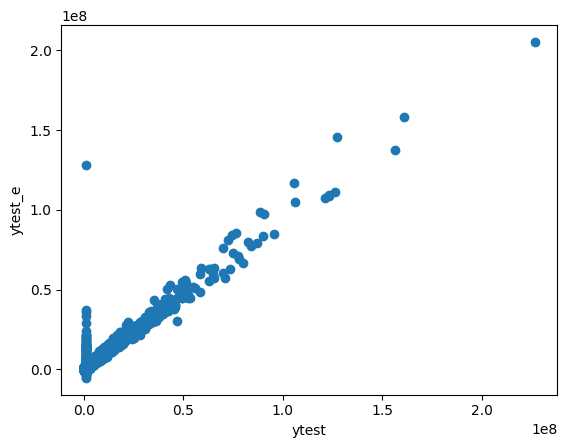

In [23]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')
plt.legend()
plt.show()

plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
 - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



In [24]:
# Paso 1: Definir los modelos a usar dentro de pipelines

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0) * RBF(length_scale=1.0)

modelos = {
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KernelRidge': KernelRidge(),
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge()
    #'GaussianProcessRegressor': GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
}

# Paso 2: Crear pipelines para cada modelo
pipelines = {}
for nombre, modelo in modelos.items():
    pipelines[nombre] = Pipeline([
        ('preproceso', mypre_fifa(col_euro=col_euro, col_stats=col_stats, cat_usr=cat_usr)),
        ('scaler', StandardScaler()),
        ('regresion', modelo)
    ])

# Paso 3: Entrenar cada pipeline y obtener predicciones
predicciones = {}
for nombre, pipeline in pipelines.items():
    print(f"Training {nombre}...")
    pipeline.fit(Xtrain, ytrain_num)  # Entrena el pipeline completo
    print(f"{nombre} trained.")
    predicciones[nombre] = pipeline.predict(Xtest)  # Almacena las predicciones


Training Lasso...
Lasso trained.
Training ElasticNet...
ElasticNet trained.
Training KernelRidge...
KernelRidge trained.
Training SGDRegressor...
SGDRegressor trained.
Training BayesianRidge...
BayesianRidge trained.


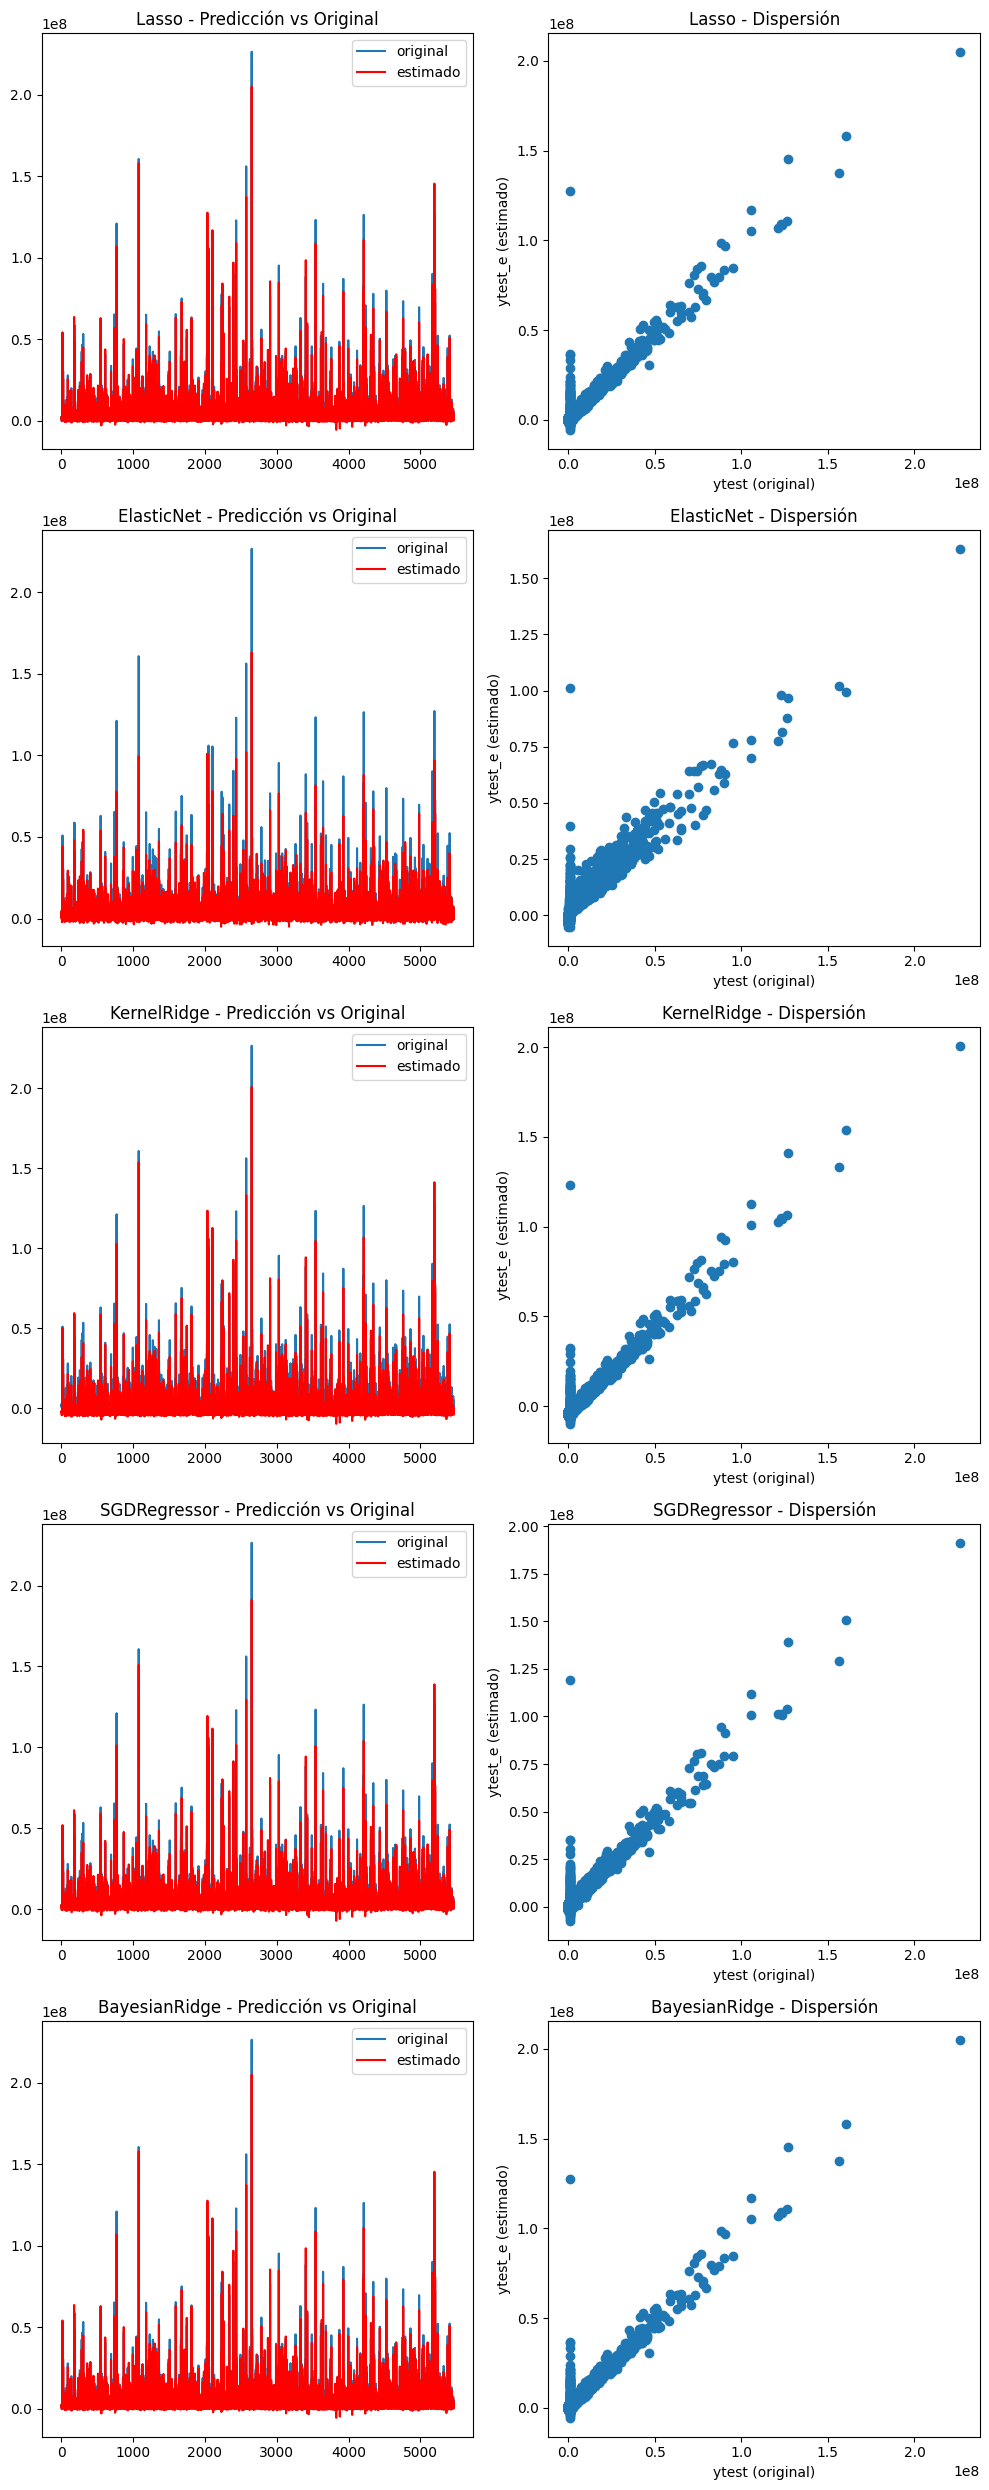

In [25]:
fig, axes = plt.subplots(len(modelos), 2, figsize=(10, len(modelos) * 5))
axes = axes.flatten()

for i, (nombre, ytest_e) in enumerate(predicciones.items()):
    # Gráfico de líneas (predicción vs original)
    axes[i * 2].plot(ytest_num, label='original')
    axes[i * 2].plot(ytest_e, 'r', label='estimado')
    axes[i * 2].set_title(f'{nombre} - Predicción vs Original')
    axes[i * 2].legend()

    # Gráfico de dispersión
    axes[i * 2 + 1].scatter(ytest_num, ytest_e)
    axes[i * 2 + 1].set_xlabel('ytest (original)')
    axes[i * 2 + 1].set_ylabel('ytest_e (estimado)')
    axes[i * 2 + 1].set_title(f'{nombre} - Dispersión')

plt.tight_layout()
plt.show()